# Assessing promotion impact on competitors using A/B testing and ANOVA

In this project, we aim to understand the effect of promotions on the frequency of price reductions by competitors. To achieve this goal, we will perform an A/B test comparing the price changes between two groups: one with promotions and one without. Then, we will conduct a One-Way ANOVA to further evaluate the impact of the promotions on different product categories. The results from this analysis will provide valuable insights into the competitive landscape and enable the company to adjust their pricing strategies accordingly, and optimize their marketing efforts and resources.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import timedelta

from scipy.stats import shapiro
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Set the desired inputs
categories = ["pasta","toilet paper", "flour and semolina"]
#categories = ["biscuits","waffles","chocolates"]

# We choose two stores located in the same street as competitors
store1 = '1049' #Osher-Ad
store2 = '1342' #Rami-Levi

# We choose period length to be assessed (in days)
period = 7

#Significance level
alpha=0.05

In [3]:
# Import promotion category data
promotion_category = pd.read_excel('promotion_id.xlsx')

promotion_data = pd.read_excel('promotion_variaty_id_2.xlsx', sheet_name='product_promotion')
promotion_data = promotion_data[promotion_data['category'].isin(categories)]
promotion_data['PromotionDescription'] = promotion_data['PromotionDescription'].astype('str')
promotion_data = pd.merge(promotion_data, promotion_category, on="PromotionID")
promotion_data.columns = ['DiscountDescription','PromotionID','category','PromotionType']
promotion_data

,DiscountDescription,PromotionID,category,PromotionType
0,מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.,10,pasta,מחיר מוזל
1,"מחיר מוזל. מוגבל ל-3 מימושים / ק""ג בקניה אחת. ...",10,pasta,מחיר מוזל
2,"מחיר מוזל. מוגבל ל-5 מימושים / ק""ג בקניה אחת. ...",10,pasta,מחיר מוזל
3,"מחיר מוזל. מוגבל ל-4 מימושים / ק""ג בקניה אחת. ...",10,pasta,מחיר מוזל
4,"מחיר מוזל. מוגבל ל-2 מימושים / ק""ג בקניה אחת. ...",10,pasta,מחיר מוזל
...,...,...,...,...
4618,מחיר מוזל. מותנה ברכישה של 100.00 ₪ ומעלה ממוצ...,93,flour and semolina,"מבצעי מועדון - מותנה ברכישה של Z ש""ח"
4619,מחיר מוזל. מותנה ברכישה של 150.00 ₪ ומעלה ממוצ...,80,flour and semolina,"מחיר מוזל - מותנה ברכישה של מעל 100 ש""ח"
4620,מחיר מוזל. מותנה ברכישה של 150.00 ₪ ומעלה ממוצ...,80,flour and semolina,"מחיר מוזל - מותנה ברכישה של מעל 100 ש""ח"
4621,מחיר מוזל. מותנה ברכישה של 199.00 ₪ ומעלה ממוצ...,80,flour and semolina,"מחיר מוזל - מותנה ברכישה של מעל 100 ש""ח"


In [4]:
def data_importing_preprocessing(categories, store, promotion_data):
    store_data = pd.DataFrame()

    for category in categories:
        category_store_data = readRDS('G:/retail data/rds data/data by store/'+category+'/'+str(store)+'.rds')
        category_store_data = pandas2ri.rpy2py_dataframe(category_store_data)
        category_store_data['Date'] = pd.to_datetime(category_store_data['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
        category_store_data['Date'] = pd.to_datetime(category_store_data['Date'], errors='coerce').sort_values()
        category_store_data['DiscountDescription'] = category_store_data['DiscountDescription'].str.replace('\n', '')
        category_store_data = pd.merge(category_store_data, promotion_data, how='left', on="DiscountDescription")
        category_store_data['category'] = category
        store_data = pd.concat([store_data, category_store_data], axis=0)
        
    return store_data

In [5]:
# Import the data of store with the promotions
store1_data = data_importing_preprocessing(categories, store1, promotion_data)
store1_data[:5]

,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,Price,Discount,FinalPrice,DiscountDescription,DiscountID,PriceSetDate,Date,PromotionID,category,PromotionType
0,7290012929793,ספגטי מחיטה מלאה פרווה טעמן 500 גרם,טעמן,פסטה ספגטי ולזניה,11.0,אושר עד,11.0,אושר עד,1049,ירושלים גבעת שאול,4.4,None,4.4,None,None,2015-07-21 08:41:10,2016-01-01,NaN,pasta,NaN
1,7290005437939,ספגטיני מספר 10 טעמן 500 גרם,טעמן,פסטה ספגטי ולזניה,11.0,אושר עד,11.0,אושר עד,1049,ירושלים גבעת שאול,3.5,None,3.5,None,0,2015-10-09 08:40:33,2016-01-01,NaN,pasta,NaN
2,8076800195033,ספגטיני מספר 3 ברילה 500 גרם,ש. שסטוביץ - ברילה,פסטה ספגטי ולזניה,11.0,אושר עד,11.0,אושר עד,1049,ירושלים גבעת שאול,4.9,None,4.9,None,None,2015-10-18 20:24:11,2016-01-01,NaN,pasta,NaN
3,8076809512268,פסטה גירנדולה מספר 34 ברילה 500 גרם,ש. שסטוביץ - ברילה,פסטה ספגטי ולזניה,11.0,אושר עד,11.0,אושר עד,1049,ירושלים גבעת שאול,4.9,None,4.9,None,None,2015-10-23 08:40:59,2016-01-01,NaN,pasta,NaN
4,8076809523738,פסטה לזניה ברילה 500 גרם,ש. שסטוביץ - ברילה,פסטה ספגטי ולזניה,11.0,אושר עד,11.0,אושר עד,1049,ירושלים גבעת שאול,19.9,None,19.9,None,None,2015-06-17 08:32:38,2016-01-01,NaN,pasta,NaN


In [6]:
# Import the data of the competitive store
store2_data = data_importing_preprocessing(categories, store2, promotion_data)
store2_data[:5]

,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,Price,Discount,FinalPrice,DiscountDescription,DiscountID,PriceSetDate,Date,PromotionID,category,PromotionType
0,8007290137241,לזניה איטלקית וילי פוד 500 גרם,וילי פוד,פסטה ספגטי ולזניה,19.0,רמי לוי,26.0,רמי לוי,1342,גבעת שאול,8.9,None,8.9,None,None,2015-02-21 10:27:26,2016-01-01,NaN,pasta,NaN
1,7290000060316,ספגטי 8 פרפקטו אסם 500 גרם,אסם,פסטה ספגטי ולזניה,19.0,רמי לוי,26.0,רמי לוי,1342,גבעת שאול,7.5,None,7.5,None,None,2015-10-06 02:21:26,2016-01-01,NaN,pasta,NaN
2,8076800315097,ספגטי בוקטיני מספר 9 ברילה 500 גרם,ש. שסטוביץ - ברילה,פסטה ספגטי ולזניה,19.0,רמי לוי,26.0,רמי לוי,1342,גבעת שאול,5.9,None,5.9,None,None,2015-12-29 02:27:37,2016-01-01,NaN,pasta,NaN
3,8076800195019,ספגטי מספר 1 קפליני ברילה 500 גרם,ש. שסטוביץ - ברילה,פסטה ספגטי ולזניה,19.0,רמי לוי,26.0,רמי לוי,1342,גבעת שאול,5.9,None,5.9,None,None,2015-12-29 02:27:37,2016-01-01,NaN,pasta,NaN
4,7290000060323,ספגטיני פרפקטו אסם 500 גרם,אסם,פסטה ספגטי ולזניה,19.0,רמי לוי,26.0,רמי לוי,1342,גבעת שאול,7.5,None,7.5,None,None,2015-10-06 02:21:27,2016-01-01,NaN,pasta,NaN


### EDA

In [7]:
def store_price_change_fun(store_data):
    
    # Get a list of all unique product descriptions
    products = store_data['ProductDescription'].unique()
    product_list = []
    for product in products:
        product_data = store_data[store_data['ProductDescription'] == product]
        product_data = product_data.sort_values(by='Date')
        # Compute the price changes
        product_data['PreviousPrice'] = product_data['FinalPrice'].shift(1)
        product_data['PriceChange'] = product_data['FinalPrice'] - product_data['PreviousPrice']
        product_list.append(product_data)
        
    product_data = pd.concat(product_list)
    product_data= product_data.reset_index(drop=True)
    
    return product_data

store1_price_changes = store_price_change_fun(store1_data)
store2_price_changes = store_price_change_fun(store2_data)

store1_price_changes['PriceChange'] = store1_price_changes['PriceChange'].replace(0, np.nan)
store2_price_changes['PriceChange'] = store2_price_changes['PriceChange'].replace(0, np.nan)

store1_price_changes['PriceDecrease'] = np.where(store1_price_changes['PriceChange'] < 0, store1_price_changes['PriceChange'], np.nan)
store2_price_changes['PriceDecrease'] = np.where(store2_price_changes['PriceChange'] < 0, store2_price_changes['PriceChange'], np.nan)

##### Frequency of price changes

We will explore the distribution of price changes to compare the price changes between the stores in order to determine if there are any differences in the behavior of the stores, which could impact the results of the A/B testing. Moreover, checking for a relationship between the date and price changes is also essential as it could provide insight into potential correlations between the date and the change in price.

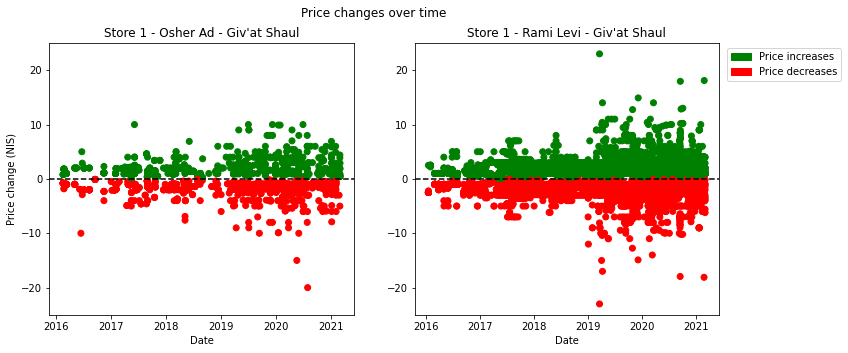

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Subplot for store 1 price changes
x1 = store1_price_changes['Date']
y1 = store1_price_changes['PriceChange']
colors1 = np.where(y1>0,'green','red')
ax1.scatter(x1, y1, c=colors1)
ax1.axhline(0, color='black', linestyle='--', label='Zero line')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price change (NIS)')
ax1.set_title("Store 1 - Osher Ad - Giv'at Shaul")


# Subplot for store 2 price changes
x2 = store2_price_changes['Date']
y2 = store2_price_changes['PriceChange']
colors2 = np.where(y2>0,'green','red')
ax2.scatter(x2, y2, c=colors2)
ax2.axhline(0, color='black', linestyle='--', label='Zero line')
ax2.set_xlabel('Date')
ax2.set_title("Store 1 - Rami Levi - Giv'at Shaul")

increase_legend = mpatches.Patch(color='green', label='Price increases')
decrease_legend = mpatches.Patch(color='red', label='Price decreases')
ax2.legend(handles=[increase_legend, decrease_legend], loc='best', bbox_to_anchor=(1.01, 1))

ax1.set_ylim(-25, 25)
ax2.set_ylim(-25, 25)

plt.suptitle("Price changes over time")
plt.show()

We can see price changes that are slightly greater in the recent years. While the number of observations in Rami Levi store is greater, the distribution of price changes between the two stores is relatively similar, with Rami Levi store exhibiting slightly more outliers.

##### Frequency of promotions

We will also investigate the promotions as part of the price decreases. This helps in identifying if there is a higher frequency of price decreases due to promotions during certain times of the year in one of the stores.

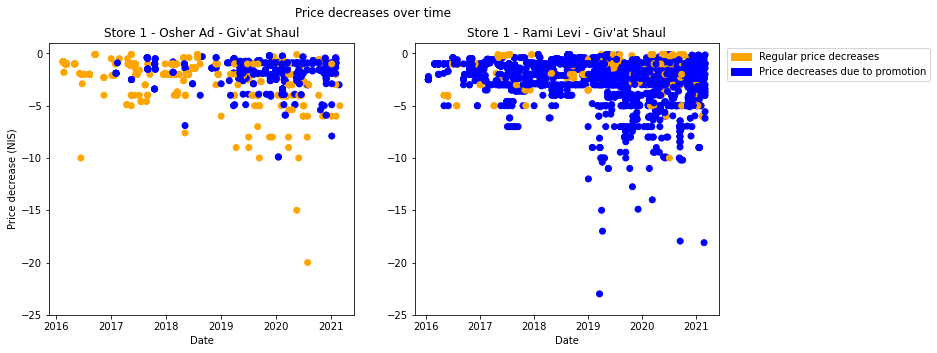

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Subplot for store 1 price changes
x1 = store1_price_changes['Date']
y1 = store1_price_changes['PriceDecrease']
colors1 = np.where(~store1_price_changes['DiscountDescription'].isna(), 'blue', 'orange')
ax1.scatter(x1, y1, c=colors1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price decrease (NIS)')
ax1.set_title("Store 1 - Osher Ad - Giv'at Shaul")

# Subplot for store 2 price changes
x2 = store2_price_changes['Date']
y2 = store2_price_changes['PriceDecrease']
colors2 = np.where(~store2_price_changes['DiscountDescription'].isna(), 'blue', 'orange')
ax2.scatter(x2, y2, c=colors2)
ax2.set_xlabel('Date')
ax2.set_title("Store 1 - Rami Levi - Giv'at Shaul")

regular_legend = mpatches.Patch(color='orange', label='Regular price decreases')
promotion_legend = mpatches.Patch(color='blue', label='Price decreases due to promotion')
ax2.legend(handles=[regular_legend, promotion_legend], loc='best', bbox_to_anchor=(1.01, 1))

ax1.set_ylim(-25, 1)
ax2.set_ylim(-25, 1)

plt.suptitle("Price decreases over time")
plt.show()

We observe that in the Rami Levi store, the size of promotions tends to be greater compared to the normal price reductions. However, in the Osher Ad store, there is no substantial difference.

##### Distribution of promotions

We will examine the distribution of promotions between the two stores.

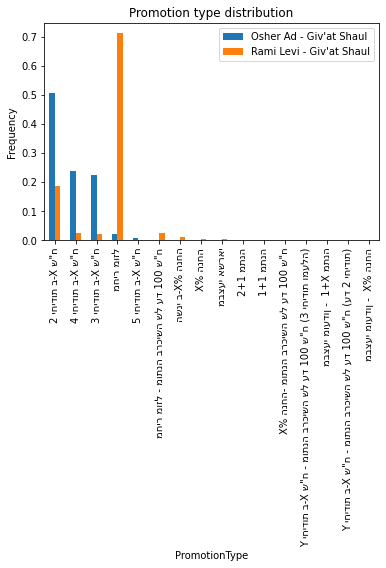

In [10]:
promo_freq1 = pd.DataFrame(store1_price_changes['PromotionType'].value_counts()/store1_price_changes['PromotionType'].value_counts().sum()).reset_index()
promo_freq1.columns = ['PromotionType',"Osher Ad - Giv'at Shaul"]
promo_freq2 = pd.DataFrame(store2_price_changes['PromotionType'].value_counts()/store2_price_changes['PromotionType'].value_counts().sum()).reset_index()
promo_freq2.columns = ['PromotionType',"Rami Levi - Giv'at Shaul"]
promo_freq = pd.merge(promo_freq1, promo_freq2, on="PromotionType", how='outer').set_index('PromotionType')

promo_freq.plot.bar(rot=0)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title("Promotion type distribution")
plt.show()

We see that the store of Osher Ad tends to use different types of promotions than the store of Rami Levi. We will check the influences of these promotions.

#### Data preparation

We use in A/B testing to determine the effect of a promotion on the price changes of a competing store. To do this, we define treatment group as follows:
- Treatment group - is the change in the frequency of price changes in the competitor store for the same products before and after the promotion in the first store.

We then compare the treatment group with two control groups:
- Control group (type 1) - is the change in the frequency of price changes in the competitor store for different products but at the same time before and after the promotion in the first store.
- Control group (type 2) - is the change in the frequency of price changes in the competitor store for the same products, but at different time periods than the promotions in the first store.

By comparing the treatment group to these two control groups, we can determine if the changes in the competitor store are truly due to the promotion or if they are due to other factors such as different time or different products.We use in A/B testing to determine the effect of a promotion on the price changes of a competing store. To do this, we define treatment group as follows:
- Treatment group - is the change in the frequency of price changes in the competitor store for the same products before and after the promotion in the first store.

We then compare the treatment group with two control groups:
- Control group (type 1) - is the change in the frequency of price changes in the competitor store for different products but at the same time before and after the promotion in the first store.
- Control group (type 2) - is the change in the frequency of price changes in the competitor store for the same products, but at different time periods than the promotions in the first store.

By comparing the treatment group to these two control groups, we can determine if the changes in the competitor store are truly due to the promotion or if they are due to other factors such as different time or different products.

In [11]:
# function to find continuous_periods in price time series to create control group of identical products to treatment but different times
def continuous_periods(data, n):
    periods = []
    start, end = 0, 0
    for i in range(1,len(data)):
        #print(data['PriceChange'])
        if data['PriceChange'][i] == 0:
            end = i
            if end - start == n-1:
                periods.append((start, end))
                start = i+1
                end = i+1
        else:
            start = i+1
            end = i+1
    for i in range(len(periods)):
        periods[i] = (periods[i][0]+1, periods[i][1]+1)
    median_order = [(x[0]+x[1]+1)/2 for x in periods]
    return median_order

In [12]:
def data_preparation(store_data, store2_data, period, group):
    
    # Get a list of all unique product descriptions
    products = store_data['ProductDescription'].unique()
    
    product_list = []
    for product in products:
        product_data = store_data[store_data['ProductDescription'] == product]
        product_data = product_data.sort_values(by='Date')
        # Compute the price changes
        product_data['PreviousPrice'] = product_data['FinalPrice'].shift(1)
        product_data['PriceChange'] = product_data['FinalPrice'] - product_data['PreviousPrice']
        
        if group=='treatment':
            # Keep just the price changes
            changed_prices = product_data[product_data['PriceChange'] != 0]
            changed_prices = changed_prices[changed_prices['PriceChange'].isnull() != True]
            product_list.append(changed_prices)
        elif group=='control_same_time':
            # Keep just the price that did not changed
            non_changed_prices = product_data[product_data['PriceChange'] == 0]
            non_changed_prices = non_changed_prices[non_changed_prices['PriceChange'].isnull() != True]
            product_list.append(non_changed_prices)
        elif group=='control_same_product':
            product_data = product_data.reset_index(drop=True)
            non_price_change_middle_periods = continuous_periods(product_data, period*2)
            filtered_product_data = product_data.iloc[non_price_change_middle_periods]
            product_list.append(filtered_product_data)
        
    product_data = pd.concat(product_list)
    
    if group=='treatment':
        # Taking just price changes due to promotions
        product_data = product_data[product_data['PromotionType'].isnull() != True]
    
    # Taking products that also exist the the store 2
    store2_products = set(store2_data['ProductDescription'])
    product_data = product_data[product_data['ProductDescription'].isin(store2_products)]
    # Filter out observations before the minimum to test
    start_date = pd.to_datetime("2019-01-01") + timedelta(days=period)
    product_data = product_data[product_data['Date'] >= start_date]
    
    return product_data

In [13]:
def adding_competitive_data(treatment_control_data, store2_data, period):
    treatment_control_data['Competitive_Num_Reductions_Before'] = 0
    treatment_control_data['Competitive_Num_Reductions_After'] = 0

    # add number of price reductions in store 2 before and after the treatment or the placebo in store 1
    for product in range(len(treatment_control_data)):
        product_in_store2 = store2_data[store2_data['ProductDescription'] == treatment_control_data['ProductDescription'][product]]

        before_treatment_control_store2 = product_in_store2[(product_in_store2['Date'] < treatment_control_data['Date'][product]) & (product_in_store2['Date'] >= (treatment_control_data['Date'][product] - timedelta(days=period)))]
        before_treatment_control_store2.loc[:, 'PreviousPrice'] = before_treatment_control_store2['FinalPrice'].shift(1)
        before_treatment_control_store2['PriceChange'] = before_treatment_control_store2['FinalPrice'] - before_treatment_control_store2['PreviousPrice']
        before_treatment_control_store2['PriceReduction'] = np.where(before_treatment_control_store2['PriceChange'] < 0, 1, 0)
        treatment_control_data['Competitive_Num_Reductions_Before'][product] = before_treatment_control_store2['PriceReduction'].sum()
    
        after_treatment_control_store2 = product_in_store2[(product_in_store2['Date'] >= treatment_control_data['Date'][product]) & (product_in_store2['Date'] < (treatment_control_data['Date'][product] + timedelta(days=period)))]
        after_treatment_control_store2.loc[:, 'PreviousPrice'] = after_treatment_control_store2['FinalPrice'].shift(1)
        after_treatment_control_store2['PriceChange'] = after_treatment_control_store2['FinalPrice'] - after_treatment_control_store2['PreviousPrice']
        after_treatment_control_store2['PriceReduction'] = np.where(after_treatment_control_store2['PriceChange'] < 0, 1, 0)
        treatment_control_data['Competitive_Num_Reductions_After'][product] = after_treatment_control_store2['PriceReduction'].sum()

    treatment_control_data['Competitive_Diff_Before_After'] = treatment_control_data['Competitive_Num_Reductions_After'] - treatment_control_data['Competitive_Num_Reductions_Before']
    
    return treatment_control_data

In [ ]:
#### treatment data

# Get the data on the price changes that occurred in store 1 due to promotions
changed_prices_data = data_preparation(store1_data, store2_data, period,'treatment')
# Get a list of the promotion categories that we will test
promotion_type_detected = pd.DataFrame(changed_prices_data['PromotionType'].unique(), columns=['PromotionType'])

# Select the first promotion type and gather data on the price reductions in store 2
treatment_i = changed_prices_data[changed_prices_data['PromotionType']==promotion_type_detected['PromotionType'][0]].reset_index(drop=True)

# Add the number of price reductions in store 2 before and after the promotion in store 1
treatment_i = adding_competitive_data(treatment_i, store2_data, period)


#### control data - other products without price changes at the same time

# Get the data on products that didn't change price at the same time as the price changes due to promotions in store 1
other_products_non_changed_prices_data = data_preparation(store1_data, store2_data, period,'control_same_time')

# Create the first control group by selecting products that didn't change price on the same day as a parallel product's price change due to promotion
other_products_control_i = pd.DataFrame(columns=treatment_i.columns[:-3])
for product in range(len(treatment_i)):
    other_products_control_i = other_products_control_i.append(other_products_non_changed_prices_data[other_products_non_changed_prices_data['Date'] == treatment_i['Date'][product]], ignore_index=True)

# Add the number of price reductions in store 2 before and after the placebo effect from store 1
other_products_control_i = adding_competitive_data(other_products_control_i, store2_data, period)


#### Control data - same products without price changes at different time

# Get the data on the same products that didn't change price but at different times
other_times_non_changed_prices_data = data_preparation(store1_data, store2_data, period,'control_same_product')

# Create the second control group by selecting the same products but at different times when they didn't change price
other_times_control_i = pd.DataFrame(columns=treatment_i.columns[:-3])
other_times_control_i = other_times_control_i.append(other_times_non_changed_prices_data)
other_times_control_i = other_times_control_i.reset_index(drop=True)

# Add the number of price reductions in store 2 before and after the placebo effect from store 1
other_times_control_i = adding_competitive_data(other_times_control_i, store2_data, period)

### A/B testing

We use A/B testing to determine the effect of a promotional offer on the price changes of a competing store.

#### Hypothesis formulation

Before conducting the A/B testing, we first formulate the null and alternative hypotheses. The null hypothesis states that there is no difference in the mean between the groups, meaning any observed difference between the group means is due to random chance and not the treatment being tested.

- The null hypothesis (H0) is that there is no significant difference in the mean price changes between the two groups (control group and treatment group) before and after the promotional offer.
- The alternative hypothesis (Ha) is that there is a significant difference in the mean price changes between the two groups after the promotional offer.

Mathematically, these hypotheses can be represented as:

$$ H_0: μ_1 - μ_2 = 0 $$
$$ H_a: μ_1 - μ_2 ≠ 0 $$

The mean of the treatment group is: 0.5384615384615384
The mean of the first control group is: 0.013963480128893663
The mean of the second control group is: -0.02631578947368421


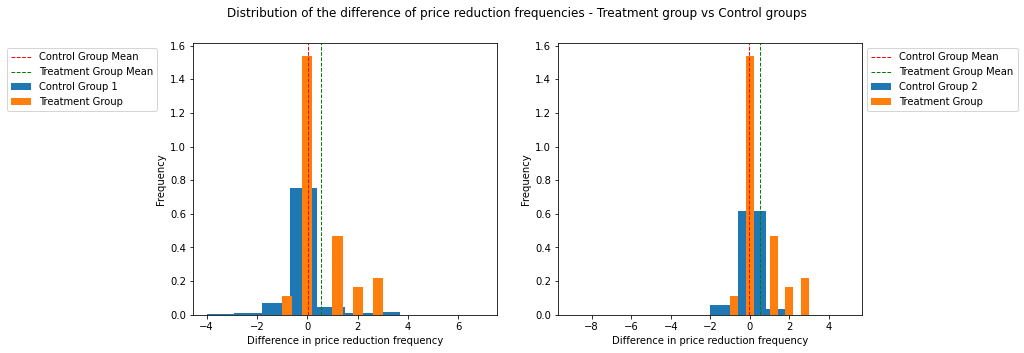

In [15]:
# Calculate the means
mean_treatment = treatment_i['Competitive_Diff_Before_After'].mean()
mean_control1 = other_products_control_i['Competitive_Diff_Before_After'].mean()
mean_control2 = other_times_control_i['Competitive_Diff_Before_After'].mean()
print('The mean of the treatment group is:',mean_treatment)
print('The mean of the first control group is:',mean_control1)
print('The mean of the second control group is:',mean_control2)

# Calculate the stds
std_treatment = treatment_i['Competitive_Diff_Before_After'].std()
std_control1 = other_products_control_i['Competitive_Diff_Before_After'].std()
std_control2 = other_times_control_i['Competitive_Diff_Before_After'].std()
# Calculate observation number
n_t = treatment_i['Competitive_Diff_Before_After'].count()
n_c1 = other_products_control_i['Competitive_Diff_Before_After'].count()
n_c2 = other_times_control_i['Competitive_Diff_Before_After'].count()

# Set up the subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the treatment group vs control group 1
ax1.hist(other_products_control_i['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Control Group 1')
ax1.hist(treatment_i['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Treatment Group')
ax1.axvline(mean_control1, color='red', linestyle='dashed', linewidth=1, label='Control Group Mean')
ax1.axvline(mean_treatment, color='green', linestyle='dashed', linewidth=1, label='Treatment Group Mean')
ax1.set_xlabel('Difference in price reduction frequency')
ax1.set_ylabel('Frequency')
ax1.legend(loc='best',bbox_to_anchor=(-0.1, 1))

# Plot the treatment group vs control group 2
ax2.hist(other_times_control_i['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Control Group 2')
ax2.hist(treatment_i['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Treatment Group')
ax2.axvline(mean_control2, color='red', linestyle='dashed', linewidth=1, label='Control Group Mean')
ax2.axvline(mean_treatment, color='green', linestyle='dashed', linewidth=1, label='Treatment Group Mean')
ax2.set_xlabel('Difference in price reduction frequency')
ax2.set_ylabel('Frequency')
ax2.legend(loc='best',bbox_to_anchor=(1, 1))

plt.suptitle("Distribution of the difference of price reduction frequencies - Treatment group vs Control groups")
plt.show()

We observe differences in the mean. We will assess it statistically.

The goal of the A/B testing is to compare two groups and determine if there is a significant difference in the mean price changes between the two groups.

#### Assumptions testing

Before conducting the A/B testing, we will also perform tests to check important assumptions in order to determine which test to use.

##### Shapiro-Wilk test

We will perform the Shapiro-Wilk test to check the normality assumption of the data. This is an important assumption to check because statistical tests like Student t-test and Welch's t-test rely on the normality of the data. If the data is not normally distributed, we will use Mann-Whitney U test to compare the means of the two groups.

##### Levene's test

We will perform Levene's test to check the homogeneity of variances between the two groups. This test is used to ensure the assumptions of equal variances for the Student t-test. If there is a significant heterogeneity of variances, we will use Welch's t-test.

#### Testing for Significance

Based on the results of the Shapiro-Wilk and Levene's tests, we will choose one of the following tests to determine if there is a significant difference among the means of the two groups:

##### Student t-test

If the assumptions of equal variances and normailty are met, we will use the Student t-test to compare the means of the two groups.

##### Welch's t-test

If the variances between the groups are not equal, we will use the Welch's t-test to compare the means of the two groups. This is important, as there could be variability due to differences in the time or products being evaluated.

##### Mann-Whitney U test

We will use Mann-Whitney U test to compare the medians of the two groups. Unlike parametric tests like Student's t-test or Welch's t-test, it is a non-parametric test and is used when the data is not normally distributed.

In [16]:
def AB_testing(treatment_df, control_df):

    mean_difference = np.mean(treatment_df) - np.mean(control_df)

    # Check the normality assumption with Shapiro-Wilk test
    shapiro_treatment = shapiro(treatment_df)
    shapiro_control = shapiro(control_df)

    if (shapiro_treatment[1] < alpha) & (shapiro_control[1] < alpha):
        print("By Shapiro-Wilk test, the data is normally distributed")

        # Check the homogeneity of variances assumption with Levene's test
        levene_test = stats.levene(treatment_df, control_df)

        if levene_test[1]< alpha:
            print("By Levene's test, the data shows significant heterogeneity of variances between the groups")

            # Use Welch's t-test to compare the means of the treatment group and control group
            t_stat, p_value = stats.ttest_ind(treatment_df, control_df, equal_var=False)

            # Compute the confidence interval of the difference of means
            se = np.sqrt(np.var(treatment_df)/len(treatment_df) + np.var(control_df)/len(control_df))
            df = (np.var(treatment_df)/len(treatment_df) + np.var(control_df)/len(control_df))**2 /((np.var(treatment_df)/len(treatment_df))**2 /(len(treatment_df)-1) + (np.var(control_df)/len(control_df))**2 / (len(control_df)-1))
            t_value = stats.t.ppf(1-alpha/2, df=df)
            ci = (mean_difference - t_value * se, mean_difference + t_value * se)

        else:
            print("By Levene's test, the data shows no significant heterogeneity of variances between the groups")

            # Use Student t-test to compare the means of the treatment group and control group
            t_stat, p_value = stats.ttest_ind(treatment_df, control_df, equal_var=True)

            # Compute the confidence interval of the difference of means
            se = np.sqrt(np.var(treatment_df)/len(treatment_df) + np.var(control_df)/len(control_df))
            t_value = stats.t.ppf(1-alpha/2, df=min(len(treatment_df), len(control_df))-1)
            ci = (mean_difference - t_value * se, mean_difference + t_value * se)

    else:
        print("By Shapiro-Wilk test, the data is not normally distributed")

        # Use Mann-Whitney U test to compare the means of the treatment group and control group
        t_stat, p_value = stats.mannwhitneyu(treatment_df, control_df)

        # Compute the confidence interval of the difference of means
        z_value = stats.norm.ppf(1-alpha/2)
        se = np.sqrt(np.var(treatment_df)/len(treatment_df) + np.var(control_df)/len(control_df))
        ci = (mean_difference - z_value * se, mean_difference + z_value * se)

    # Check if the p-values are less than 0.05
    if p_value < alpha:
        print("By the statistical test, there is a significant difference in price reduction frequency between the treatment group and control group")
    else:
        print("By the statistical test, there is not a significant in price reduction frequency difference between the treatment group and control group")


    if ci[0] > 0:
        print("The treatment group has a higher frequency of price changes compared to control group with a confidence interval of ", ci)
    else:
        print("The control group has a higher or equal frequency of price changes compared to treatment group with a confidence interval of ", ci)
    
    return t_stat, ci, df

In [17]:
# Use A/B testing procedure to compare the means of the treatment group and each control group
print('Testing frequency of price changes when comparing to other products without price changes at the same time:')
t_stat1, conf_int1, df1 = AB_testing(treatment_i['Competitive_Diff_Before_After'], other_products_control_i['Competitive_Diff_Before_After'])
print('\nTesting frequency of price changes when comparing to same products without price changes at different time:')
t_stat2, conf_int2, df2 = AB_testing(treatment_i['Competitive_Diff_Before_After'], other_times_control_i['Competitive_Diff_Before_After'])

Testing frequency of price changes when comparing to other products without price changes at the same time:
By Shapiro-Wilk test, the data is normally distributed
By Levene's test, the data shows significant heterogeneity of variances between the groups
By the statistical test, there is a significant difference in price reduction frequency between the treatment group and control group
The treatment group has a higher frequency of price changes compared to control group with a confidence interval of  (0.31536035097330295, 0.7336357656919865)

Testing frequency of price changes when comparing to same products without price changes at different time:
By Shapiro-Wilk test, the data is normally distributed
By Levene's test, the data shows significant heterogeneity of variances between the groups
By the statistical test, there is a significant difference in price reduction frequency between the treatment group and control group
The treatment group has a higher frequency of price changes comp

##### Confidence interval analysis

We will assess the precision of our sample mean by computing a confidence interval that will gives us a more complete picture of the results.

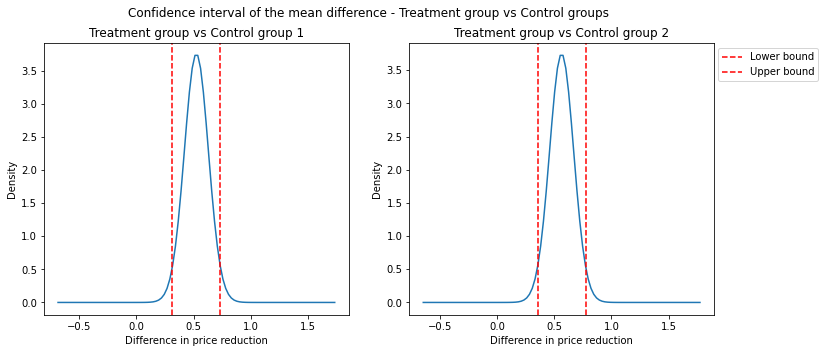

In [18]:
# Plot the confidence interval
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the treatment group vs control group 1
x1 = np.linspace(conf_int1[0]-1, conf_int1[1]+1, 100)
y1 = stats.t.pdf(x1, df1, loc=mean_treatment-mean_control1, scale=np.sqrt(std_control1**2/n_c1 + std_treatment**2/n_t))
ax1.plot(x1, y1)
ax1.axvline(conf_int1[0], color='red', linestyle='--', label='Lower bound')
ax1.axvline(conf_int1[1], color='red', linestyle='--', label='Upper bound')
ax1.set_xlabel('Difference in price reduction')
ax1.set_ylabel('Density')
ax1.set_title('Treatment group vs Control group 1')

# Plot the treatment group vs control group 2
x2 = np.linspace(conf_int2[0]-1, conf_int2[1]+1, 100)
y2 = stats.t.pdf(x2, df2, loc=mean_treatment-mean_control2, scale=np.sqrt(std_control2**2/n_c2 + std_treatment**2/n_t))
ax2.plot(x2, y2)
ax2.axvline(conf_int2[0], color='red', linestyle='--', label='Lower bound')
ax2.axvline(conf_int2[1], color='red', linestyle='--', label='Upper bound')
ax2.set_xlabel('Difference in price reduction')
ax2.set_ylabel('Density')
ax2.set_title('Treatment group vs Control group 2')
ax2.legend(loc='best',bbox_to_anchor=(1.36, 1))

plt.suptitle("Confidence interval of the mean difference - Treatment group vs Control groups")
plt.show()

The tests we used above ensure a comprehensive evaluation of promotion impact on the price changes of the competing store. By comparing the frequency of price changes in the competitor store before and after the promotion in the first store, we are able to account for differences in time or products being evaluated, and the possibility of unequal variances due to differences in time or products. The results of these tests suggest that the changes observed in the competitor store's price changes are likely due to the promotion in the first store and supported also by a confidence interval above 0.

Based on these results, we can conclude that the promotion in the first store likely had an impact on the price changes in the competitor store. However, the A/B testing does not account for the effect of confounding variables that might affect the price changes of the competing store.

### One-way ANOVA


So far we were using A/B testing to compare the effect of a promotional offer on the price changes of a competing store, where the goal is to determine if there is a significant difference in the frequency of price changes between the two groups - one with the promotional offer and one without. 

Now we will use one-way ANOVA with multiple groups to compare the differences in the means of various product types (e.g., toilet paper, pasta, and flour and semolina). This analysis will provide insight into the impact of the promotional offer on different product categories and better allocate the marketing resources.

#### Hypothesis formulation

We will test the differences in means of different product types in relation to the effect of a promotional offer. The null and alternative hypotheses can be expressed as:

$H_0: \mu_1 = \mu_2 = \mu_3$

$H_a:$ At least one $μ_i≠μ_j (i ≠ j)$

- The null hypothesis states that the population means of the effect of the promotional offer on the price changes of all three product types are equal. 
- The alternative hypothesis states that at least one of the population means of the effect of the promotional offer on the price changes of the three product types is different.

#### Assumptions testing

As before, also here we will test the assumptions of normality (with Shapiro-Wilk test) and equality of variances (with Levene's test).

#### Testing for Significance

To determine if there is a significant difference among the means of multiple groups, we will use two tests:

##### F-test

We use F-test to determine if there is significant difference among the means of multiple groups. The F-statistic is calculated by dividing the mean square between-groups by the mean square within-groups.

##### Kruskal-Wallis test

We will use Kruskal-Wallis test if F-test fails when the variances are not equal or assumption of normality is not met.

#### Post-hoc analysis

Afte performing the one-way ANOVA test, we will further explore the results of the test with Tukey's HSD test to provide more detailed insights into the impact of the promotional offer on different product categories.

##### Tukey's Honest Significant Difference (HSD)

Tukey's test is a commonly used method for multiple comparisons in the context of ANOVA, as it can effectively control for the Type I error rate by adjusting the significance level based on the number of comparisons being made. This helps to avoid false positive results and increases the accuracy of the multiple comparisons. We use it to determine which pairs of category means are significantly different from each other. 

In [19]:
def conduct_anova(treatment_i, categories):
    groups = []
    for i in range(len(categories)):
        groups.append(treatment_i[treatment_i['category'] == categories[i]])
        
    groups_df = pd.concat([group[['Competitive_Diff_Before_After','category']] for group in groups])
    groups_df = groups_df.reset_index(drop=True)
    
    # Check normality assumption for each group
    print('Normality assumption test')
    normality_assumption = True
    for i, group in enumerate(groups):
        s_statistic, p_value = stats.shapiro(group['Competitive_Diff_Before_After'])
        if p_value < alpha:
            normality_assumption = False
            print(f"Group {i+1} does not follow a normal distribution (p = {p_value:.4f})")
        
    if normality_assumption:
        print("All groups follow a normal distribution")

    # Check equality of variances assumption
    print("Equality of variances test:")
    l_statistic, p_value = stats.levene(*[group['Competitive_Diff_Before_After'] for group in groups])
    if p_value > alpha:
        print(f"Groups have equal variances (p = {p_value:.4f})")
        
        # Conduct the F-test ANOVA
        statistic, p_value = stats.f_oneway(*[group['Competitive_Diff_Before_After'] for group in groups])
        print("F-test ANOVA results:")
        if p_value < alpha:
            print(f"There is a significant difference in the means of the groups (f = {f_statistic:.4f}, p = {p_value:.4f})")
        else:
            print(f"There is no significant difference in the means of the groups (f = {f_statistic:.4f}, p = {p_value:.4f})")
        
    else:
        print(f"Groups have unequal variances (p = {p_value:.4f})")

        # Kruskal-Wallis test
        group1 = groups_df[groups_df['category'] == categories[0]]['Competitive_Diff_Before_After'].values
        group2 = groups_df[groups_df['category'] == categories[1]]['Competitive_Diff_Before_After'].values
        group3 = groups_df[groups_df['category'] == categories[2]]['Competitive_Diff_Before_After'].values

        statistic, p_value = stats.kruskal(group1, group2, group3)
        #kruskal_statistic, p_value = stats.kruskal(*[group['Competitive_Diff_Before_After'] for group in groups_df])
        print("Kruskal-Wallis test results:")
        if p_value < alpha:
            print(f"There is a significant difference in the medians of the groups (Kruskal-Wallis statistic = {statistic:.4f}, p = {p_value:.4f})")
        else:
            print(f"There is no significant difference in the medians of the groups (Kruskal-Wallis statistic = {statistic:.4f}, p = {p_value:.4f})")

    # Perform multiple comparisons with Tukey HSD
    tukey = pairwise_tukeyhsd(endog=groups_df['Competitive_Diff_Before_After'], groups=groups_df['category'], alpha=0.05)
    print(tukey.summary())
    
    # Extract the conclusions from the Tukey results
    tukey_df = pd.DataFrame(tukey.summary())
    tukey_df.columns = tukey_df.iloc[0].apply(str)
    tukey_df = tukey_df.drop(0).reset_index(drop=True)
    conf_intervals = tukey.confint
    reject_null = tukey.reject

    for i in range(len(tukey_df)):
        if reject_null[i]:
            print(f"{tukey_df['group1'][i]} and {tukey_df['group2'][i]} have a significant difference (95% confidence interval: {conf_intervals[i]})")
        else:
            print(f"{tukey_df['group1'][i]} and {tukey_df['group2'][i]} have no significant difference (95% confidence interval: {conf_intervals[i]})")

    return statistic, tukey

In [20]:
test_statistic, tukey = conduct_anova(treatment_i, categories)

Normality assumption test
Group 1 does not follow a normal distribution (p = 0.0041)
Group 2 does not follow a normal distribution (p = 0.0000)
Group 3 does not follow a normal distribution (p = 0.0000)
Equality of variances test:
Groups have unequal variances (p = 0.0000)
Kruskal-Wallis test results:
There is a significant difference in the medians of the groups (Kruskal-Wallis statistic = 32.4448, p = 0.0000)
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
flour and semolina        pasta   1.5226  0.001  1.0759  1.9692   True
flour and semolina toilet paper  -0.1106 0.8484 -0.6205  0.3993  False
             pasta toilet paper  -1.6332  0.001 -2.2138 -1.0525   True
----------------------------------------------------------------------
flour and semolina and pasta have a significant difference (95% confidence interval: [1.

To illustrate the differences between the product categories we will display the distribution og the frequency change of price reductions

The mean of group 1 (pasta) is: 1.6956521739130435
The mean of group 2 (toilet paper) is: 0.0625
The mean of group 3 (flour and semolina) is: 0.17307692307692307


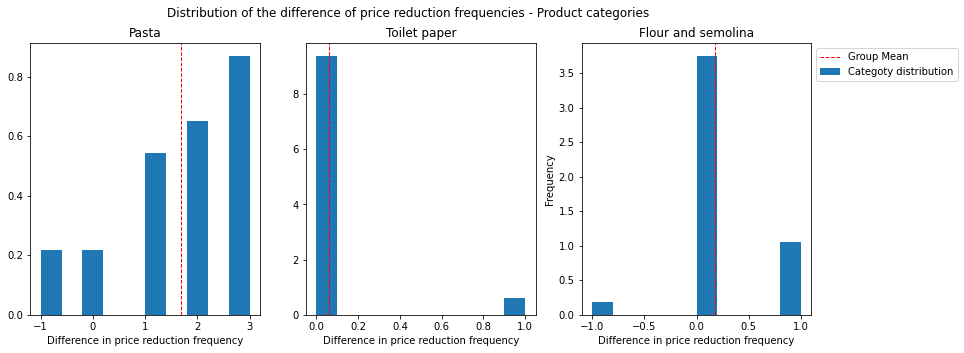

In [41]:
# Calculate the means
mean_group1 = treatment_i[treatment_i['category'] == categories[0]]['Competitive_Diff_Before_After'].mean()
mean_group2 = treatment_i[treatment_i['category'] == categories[1]]['Competitive_Diff_Before_After'].mean()
mean_group3 = treatment_i[treatment_i['category'] == categories[2]]['Competitive_Diff_Before_After'].mean()
print('The mean of group 1 (pasta) is:',mean_group1)
print('The mean of group 2 (toilet paper) is:',mean_group2)
print('The mean of group 3 (flour and semolina) is:',mean_group3)

# Set up the subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

# Plot group 1
ax1.hist(treatment_i[treatment_i['category'] == categories[0]]['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Categoty distribution')
ax1.axvline(mean_group1, color='red', linestyle='dashed', linewidth=1, label='Group Mean')
ax1.set_xlabel('Difference in price reduction frequency')
ax1.set_title('Pasta')

# Plot group 2
ax2.hist(treatment_i[treatment_i['category'] == categories[1]]['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Categoty distribution')
ax2.axvline(mean_group2, color='red', linestyle='dashed', linewidth=1, label='Group Mean')
ax2.set_xlabel('Difference in price reduction frequency')
ax2.set_title('Toilet paper')

# Plot group 3
ax3.hist(treatment_i[treatment_i['category'] == categories[2]]['Competitive_Diff_Before_After'], bins=10, alpha=1, density=True, label='Categoty distribution')
ax3.axvline(mean_group3, color='red', linestyle='dashed', linewidth=1, label='Group Mean')
ax3.set_xlabel('Difference in price reduction frequency')
ax3.set_ylabel('Frequency')
ax3.set_title('Flour and semolina')
ax3.legend(loc='best',bbox_to_anchor=(1, 1))

plt.suptitle("Distribution of the difference of price reduction frequencies - Product categories")
plt.show()

Our test results we indicate that offering promotions on pasta had a significant effect on the behavior of the competing store, compared to promotions on toilet paper and flour and semolina. 

To conclude, from our A/B testing and ANOVA testing, we can recommend to the store manager to focus their promotional efforts on specific type of promotions and specific product categories that do not significantly affect the behavior of the competing store, thus avoiding competition. This will also help the store to gain a strategic advantage over their competitors by focusing on product categories and types of promotions where they have a significant advantage over their competitors.